# RAF MACHINE LEARNING

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import glob
from datetime import timedelta, datetime
%matplotlib inline
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In this notebook, we will walk through solving a complete machine learning problem using a real-world dataset. 
### Project definition
__Use the provided SDR by DTAG to develop a model that can predict a call fraud, and then interpret the results to find the variables that are most predictive of the score.__

This is a supervised machine learning task: given a set of data with targets (in this case the RAF_BARRED) included, we want to train a model that can learn to map the features  to the target. 

* Supervised problem: we are given both the features and the target

During training, we want the model to learn the relationship between the features and the score so we give it both the features and the answer. Then, to test how well the model has learned, we evaluate it on a testing set where it has never seen the answers! 

# Data Cleaning and Formatting

## Load in the Data and Examine

We will be loading our data into a pandas dataframe, one of the most useful data structures for data science.

In [2]:
path = r'C:\Users\DS\Project\Moco\dataDTAG'
all_files = glob.glob(path + "/*.dat")

li = []

for filename in all_files:
    df = pd.read_csv(filename,delimiter=";",names=['CDR_ID','PRODUCT_ID','PRODUCT_NAME','SYSTEM_ID','BILLING_TAG','IMSI','MSISDN','IMEI','EVENT_NAME','HOME_COUNTRY_ID','HOME_COUNTRY_NAME','VISITED_COUNTRY_ID','VISITED_COUNTRY_NAME','HOME_NETWORK_ID','HOME_NETWORK_NAME','HOME_PLMN_CODE','VISITED_NETWORK_ID','VISITED_NETWORK_NAME','CLI_IN','CLI_OUT','DN_ORIG','DN_IN','DN_OUT','DN_IN_NOA','REDIRECTION_NUMBER','CALL_TYPE','ROAMING_TYPE','SERVICE_KEY_IN','CURRENT_MSC_GT','SCCP_CALLED_GT','SCCP_CALLING_GT','CALL_END_CLEAR_CAUSE_ID','CALL_END_CLEAR_CAUSE_NAME','CALL_END_NETWORK_CLEAR_CAUSE','SESSION_START_TS','SESSION_END_TS','SESSION_DESC','SESSION_TS_ANSWER','SESSION_TS_DISCONNECT','SESSION_DUR_SEC','EXTERNAL_CALL_REF_NUM','ICA_TRANSLATED_NUMBER','HSC_TRANSLATED_NUMBER','HSC_EXTERNAL_TRANS_NUMBER','DID_NUMBER','CLI_DELIVERY','HSC_FLAG','HRR_FLAG','RAF_FLAG','ICA_FLAG','HSC_REASON','HRR_REASON','ICA_REASON','DISCONNECT_LEG','MATCHING_RULE_NUMBER','ICA_COLLISION_RULE_ID','M_REMOTEGATE','IS_HRR_FOR_REMOTE_FLAG','SMS_TEXT','LANGUAGE_NUM','SMS_CALLBACK_NUM','SMS_TYPE','OWNER_BILLING_TAG','INCOMING_CALL_DIRECTION','OUTGOING_CALL_DIRECTION','CALL_REFERENCE','SUB_SERVICE_BILLING_TAG','ICA_ACTION','CAMEL_PHASE','ICA_COMM_ID','CAMEL_USER','CALL_REFERENCE_LEG2','SERVICE_TYPE_LEG2','RAF_NORMALIZE_TYPE','RAF_DN_PRE_NORMALIZATION','RAF_NORMALIZED_DN','RAF_ACTIVATED_RULE_ID','RAF_EVENT_REPLY','RAF_STATUS','CALL_CONTEXT_ID','RAF_BARRING_CASE_ID','RAF_MONITORED_RULE_ID','RAF_EMAIL_NOTIFICATION_FLAG','RAF_CRM_NOTIFICATION_FLAG','RAF_SMS_NOTIFICATION_FLAG','GDA_EXTERNAL_CALL_REF_NUM','HANDLE_TAP_IND','IS_SMS_SENT','SMS_CLEAR_CAUSE','CALL_REFERENCE_LEG3','IMSI_PREFIX_HOME','IMSI_PREFIX_VISITED','AFFILIATE_ID','RAF_ACTIVATED_RULE_ON_ANSWER'])
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
df.head()

,CDR_ID,PRODUCT_ID,PRODUCT_NAME,SYSTEM_ID,BILLING_TAG,IMSI,MSISDN,IMEI,EVENT_NAME,HOME_COUNTRY_ID,HOME_COUNTRY_NAME,VISITED_COUNTRY_ID,VISITED_COUNTRY_NAME,HOME_NETWORK_ID,HOME_NETWORK_NAME,HOME_PLMN_CODE,VISITED_NETWORK_ID,VISITED_NETWORK_NAME,CLI_IN,CLI_OUT,DN_ORIG,DN_IN,DN_OUT,DN_IN_NOA,REDIRECTION_NUMBER,CALL_TYPE,ROAMING_TYPE,SERVICE_KEY_IN,CURRENT_MSC_GT,SCCP_CALLED_GT,SCCP_CALLING_GT,CALL_END_CLEAR_CAUSE_ID,CALL_END_CLEAR_CAUSE_NAME,CALL_END_NETWORK_CLEAR_CAUSE,SESSION_START_TS,SESSION_END_TS,SESSION_DESC,SESSION_TS_ANSWER,SESSION_TS_DISCONNECT,SESSION_DUR_SEC,EXTERNAL_CALL_REF_NUM,ICA_TRANSLATED_NUMBER,HSC_TRANSLATED_NUMBER,HSC_EXTERNAL_TRANS_NUMBER,DID_NUMBER,CLI_DELIVERY,HSC_FLAG,HRR_FLAG,RAF_FLAG,ICA_FLAG,HSC_REASON,HRR_REASON,ICA_REASON,DISCONNECT_LEG,MATCHING_RULE_NUMBER,ICA_COLLISION_RULE_ID,M_REMOTEGATE,IS_HRR_FOR_REMOTE_FLAG,SMS_TEXT,LANGUAGE_NUM,SMS_CALLBACK_NUM,SMS_TYPE,OWNER_BILLING_TAG,INCOMING_CALL_DIRECTION,OUTGOING_CALL_DIRECTION,CALL_REFERENCE,SUB_SERVICE_BILLING_TAG,ICA_ACTION,CAMEL_PHASE,ICA_COMM_ID,CAMEL_USER,CALL_REFERENCE_LEG2,SERVICE_TYPE_LEG2,RAF_NORMALIZE_TYPE,RAF_DN_PRE_NORMALIZATION,RAF_NORMALIZED_DN,RAF_ACTIVATED_RULE_ID,RAF_EVENT_REPLY,RAF_STATUS,CALL_CONTEXT_ID,RAF_BARRING_CASE_ID,RAF_MONITORED_RULE_ID,RAF_EMAIL_NOTIFICATION_FLAG,RAF_CRM_NOTIFICATION_FLAG,RAF_SMS_NOTIFICATION_FLAG,GDA_EXTERNAL_CALL_REF_NUM,HANDLE_TAP_IND,IS_SMS_SENT,SMS_CLEAR_CAUSE,CALL_REFERENCE_LEG3,IMSI_PREFIX_HOME,IMSI_PREFIX_VISITED,AFFILIATE_ID,RAF_ACTIVATED_RULE_ON_ANSWER
0,27811518400,900001,MOCO,4,999999,262017444077152,491605839415,NaN,IDP,164,GERMANY,175,SWITZERLAND,58,26201,NaN,39,22803.0,4.916058e+11,4.916058e+11,491733268714,4.91733e+11,4.91733e+11,4,NaN,MO,OUT,2,41789310205,4917007525,41789310202,18,DISCONNECT,16,27.06.19 06:50:16.304,27.06.19 07:00:00.104,DISCONNECT,27.06.19 06:50:23.825,27.06.19 07:00:00.104,00:09:36,04D11423409274,NaN,NaN,NaN,NaN,0,0,0,1,1,NONE,NONE,16,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,24.0,27811518400,999999,0,2,0,0,27811518401,0,1,491733268714,491733268714,NaN,3,0,97b2cba5-0a81-42c8-0661-d3dd7b084889,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27812634300,900001,MOCO,4,999999,$2a$04$m3vFo49du.gqajd85FBEne6ey0BIWyBE55AoFBF...,$2a$04$Bnykut954sIf2sEmwuDmoO2c0JXnb.r3BeqHd.l...,NaN,IDP,164,GERMANY,105,POLAND,58,26201,NaN,55,26002.0,NaN,NaN,491712XXXXXX,NaN,NaN,4,NaN,MO,OUT,2,48602007070,4917007529,48602007070,15,ROUTING_FAILURE,19,27.06.19 06:59:56.214,27.06.19 07:00:00.100,ROUTING_FAILURE,NaN,NaN,00:00:00,2E864D32A3,NaN,NaN,NaN,NaN,0,0,0,1,1,NONE,NONE,16,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,24.0,27812634300,999999,0,2,0,0,27812634301,0,1,491712XXXXXX,491712XXXXXX,NaN,3,0,97bb8a8b-0a81-42c8-0661-d3ddc116cd0f,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27812642000,900001,MOCO,4,999999,$2a$04$m3vFo49du.gqajd85FBEney5WXxNPhj/6rWUrI8...,$2a$04$Bnykut954sIf2sEmwuDmoOQ3TQrwdVBoChy/B6b...,NaN,IDP,164,GERMANY,182,GREECE,58,26201,NaN,296,20201.0,NaN,NaN,491700XXXXXX,NaN,NaN,4,NaN,MO,OUT,2,30971400000,4917007531,30971400000,8,NORMAL,0,27.06.19 07:00:00.137,27.06.19 07:00:00.143,NORMAL,NaN,NaN,00:00:00,04D114844072C2,NaN,NaN,NaN,NaN,0,0,0,1,1,NONE,NONE,16,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,24.0,27812642000,999999,0,2,0,0,27812642001,0,1,491700XXXXXX,491700XXXXXX,BL_57,2,1,97bb8a8b-0a81-42c8-0661-d3dd1a61d654,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27812559300,900001,MOCO,4,999999,$2a$04$m3vFo49du.gqajd85FBEne0.nmboVB9WIIhaDKj...,$2a$04$Bnykut954sIf2sEmwuDmoO/BWbhPRndiJz6NPDr...,NaN,IDP,164,GERMANY,101,CROATIA,58,26201,NaN,324,21901.0,NaN,NaN,4915121XXXXXX,NaN,NaN,4,NaN,MO,OUT,2,385980110,4917007531,385980110,16,NO_ANSWER,0,27.06.19 06:59:17.042,27.06.19 07:00:00.214,NO_ANSWER,NaN,NaN,00:00:00,04D114A300F530,NaN,NaN,NaN,NaN,0,0,0,1,1,NONE,NONE,16,1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1,24.0,27812559300,999999,0,2,0,0,27812559301,0,1,4915121XXXXXX,4915121XXXXXX,NaN,3,0,97babafc-0a81-42c8-0661-d3dd21175675,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27812642100,90

In [93]:
df_block = df[df['RAF_EVENT_REPLY'] == 1 ]

In [94]:
df_block['RAF_NORMALIZE_TYPE'].value_counts()

2    3830
1    1370
3     162
4      18
Name: RAF_NORMALIZE_TYPE, dtype: int64

## Missing Values

In [310]:
null_columns = df.columns[df.isna().all()].tolist()

In [311]:
df = df.drop(null_columns,axis=1)

In [312]:
df.shape

(291605, 71)

In [313]:
col_not_relevant = []
for col in df.columns.values:
    if len(df[col].value_counts()) == 1:
        col_not_relevant.append(col)
print(col_not_relevant)

['PRODUCT_ID', 'PRODUCT_NAME', 'SYSTEM_ID', 'BILLING_TAG', 'EVENT_NAME', 'SERVICE_KEY_IN', 'CLI_DELIVERY', 'HSC_FLAG', 'HRR_FLAG', 'RAF_FLAG', 'ICA_FLAG', 'HSC_REASON', 'HRR_REASON', 'ICA_REASON', 'DISCONNECT_LEG', 'IS_HRR_FOR_REMOTE_FLAG', 'INCOMING_CALL_DIRECTION', 'OUTGOING_CALL_DIRECTION', 'SUB_SERVICE_BILLING_TAG', 'ICA_ACTION', 'ICA_COMM_ID', 'CAMEL_USER', 'SERVICE_TYPE_LEG2', 'RAF_MONITORED_RULE_ID', 'RAF_EMAIL_NOTIFICATION_FLAG', 'RAF_SMS_NOTIFICATION_FLAG']


#### We see that other product like ICA and HSC HRR are not relevant here because it's only RAF and RAF_FLAG not relevant too because it's only RAF product , we can see too that DTAG not use any notification ( email or SMS ) 

In [314]:
df = df.drop(col_not_relevant,axis=1)

In [315]:
df.shape

(291605, 45)

*drop all columns containing unique values*

In [316]:
df = df.drop(["CDR_ID","CALL_CONTEXT_ID","RAF_BARRING_CASE_ID","CALL_REFERENCE","CALL_REFERENCE_LEG2"],axis=1)

*drop all columns containing huge number of null*

In [317]:
df = df.drop("REDIRECTION_NUMBER",axis=1)

*drop all duplicate columns (e.g in each row same value in the two columns )*

In [318]:
df = df.drop("SCCP_CALLING_GT",axis=1)

*columns MSISDN and DN_ORIG are for the hug majority the same has CLI_IN/OUT and DN_IN/OUT*

In [319]:
df = df.drop(["CLI_IN","CLI_OUT","DN_IN","DN_OUT"],axis=1)

In [320]:
df.shape

(291605, 34)

*later we will remove all the columns "%NAME%" to but for the EDA part it's more clear with*

# Exploratory Data Analysis

In [321]:
df.head()

,IMSI,MSISDN,HOME_COUNTRY_ID,HOME_COUNTRY_NAME,VISITED_COUNTRY_ID,VISITED_COUNTRY_NAME,HOME_NETWORK_ID,HOME_NETWORK_NAME,VISITED_NETWORK_ID,VISITED_NETWORK_NAME,DN_ORIG,DN_IN_NOA,CALL_TYPE,ROAMING_TYPE,CURRENT_MSC_GT,SCCP_CALLED_GT,CALL_END_CLEAR_CAUSE_ID,CALL_END_CLEAR_CAUSE_NAME,CALL_END_NETWORK_CLEAR_CAUSE,SESSION_START_TS,SESSION_END_TS,SESSION_DESC,SESSION_TS_ANSWER,SESSION_TS_DISCONNECT,SESSION_DUR_SEC,EXTERNAL_CALL_REF_NUM,CAMEL_PHASE,RAF_NORMALIZE_TYPE,RAF_DN_PRE_NORMALIZATION,RAF_NORMALIZED_DN,RAF_ACTIVATED_RULE_ID,RAF_EVENT_REPLY,RAF_STATUS,RAF_CRM_NOTIFICATION_FLAG
0,262017444077152,491605839415,164,GERMANY,175,SWITZERLAND,58,26201,39,22803.0,491733268714,4,MO,OUT,41789310205,4917007525,18,DISCONNECT,16,27.06.19 06:50:16.304,27.06.19 07:00:00.104,DISCONNECT,27.06.19 06:50:23.825,27.06.19 07:00:00.104,00:09:36,04D11423409274,2,1,491733268714,491733268714,NaN,3,0,0
1,$2a$04$m3vFo49du.gqajd85FBEne6ey0BIWyBE55AoFBF...,$2a$04$Bnykut954sIf2sEmwuDmoO2c0JXnb.r3BeqHd.l...,164,GERMANY,105,POLAND,58,26201,55,26002.0,491712XXXXXX,4,MO,OUT,48602007070,4917007529,15,ROUTING_FAILURE,19,27.06.19 06:59:56.214,27.06.19 07:00:00.100,ROUTING_FAILURE,NaN,NaN,00:00:00,2E864D32A3,2,1,491712XXXXXX,491712XXXXXX,NaN,3,0,0
2,$2a$04$m3vFo49du.gqajd85FBEney5WXxNPhj/6rWUrI8...,$2a$04$Bnykut954sIf2sEmwuDmoOQ3TQrwdVBoChy/B6b...,164,GERMANY,182,GREECE,58,26201,296,20201.0,491700XXXXXX,4,MO,OUT,30971400000,4917007531,8,NORMAL,0,27.06.19 07:00:00.137,27.06.19 07:00:00.143,NORMAL,NaN,NaN,00:00:00,04D114844072C2,2,1,491700XXXXXX,491700XXXXXX,BL_57,2,1,0
3,$2a$04$m3vFo49du.gqajd85FBEne0.nmboVB9WIIhaDKj...,$2a$04$Bnykut954sIf2sEmwuDmoO/BWbhPRndiJz6NPDr...,164,GERMANY,101,CROATIA,58,26201,324,21901.0,4915121XXXXXX,4,MO,OUT,385980110,4917007531,16,NO_ANSWER,0,27.06.19 06:59:17.042,27.06.19 07:00:00.214,NO_ANSWER,NaN,NaN,00:00:00,04D114A300F530,2,1,4915121XXXXXX,4915121XXXXXX,NaN,3,0,0
4,$2a$04$m3vFo49du.gqajd85FBEne.ZMTQ1xguNZa6XgiA...,$2a$04$Bnykut954sIf2sEmwuDmoOH5/puP4OEVFQsK8mW...,105,POLAND,164,GERMANY,55,26002,58,26201.0,48510XXXXXX,4,MO,INB,491700970000,491600980760,8,NORMAL,0,27.06.19 07:00:00.218,27.06.19 07:00:00.219,NORMAL,NaN,NaN,00:00:00,04D114B3805142,2,1,48510XXXXXX,48510XXXXXX,HMN_49,2,1,1


In [322]:
df[df['RAF_ACTIVATED_RULE_ID'].notnull()]['RAF_STATUS'].value_counts()

1    168744
3      5380
0       262
Name: RAF_STATUS, dtype: int64

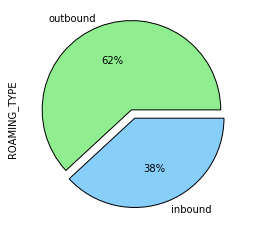

In [323]:
df['ROAMING_TYPE'].value_counts().plot(kind="pie",autopct='%1.0f%%',colors=['lightgreen', 'lightskyblue'],explode=(0.1, 0),figsize=(4,4),labels=['outbound','inbound']);

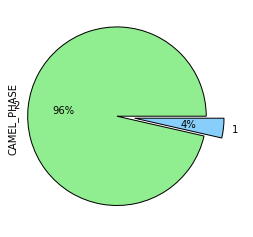

In [324]:
df["CAMEL_PHASE"].value_counts().plot(kind="pie",autopct='%1.0f%%',colors=['lightgreen', 'lightskyblue'],explode=(0.2, 0),figsize=(4,4));

In [325]:
df['CALL_TYPE'].value_counts()

MO    291440
MF       165
Name: CALL_TYPE, dtype: int64

### RAF SDR explanation

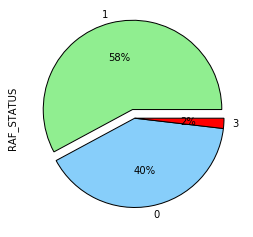

In [326]:
df["RAF_STATUS"].value_counts().plot(kind="pie",autopct='%1.0f%%',colors=['lightgreen', 'lightskyblue','red'],explode=(0.1, 0,0),figsize=(4,4));

* RAF_RELEASE   --> RAF_EVENT_REPLY = 1 
* RAF_CONTINUE/CONNECT   --> RAF_EVENT_REPLY = 2 
* RAF_CALL_SKIPPED_BY_WL_FILTER --> RAF_STATUS = 1
* CALL BAR BY RAF --> RAF_STATUS = 3

In [327]:
df.head()

,IMSI,MSISDN,HOME_COUNTRY_ID,HOME_COUNTRY_NAME,VISITED_COUNTRY_ID,VISITED_COUNTRY_NAME,HOME_NETWORK_ID,HOME_NETWORK_NAME,VISITED_NETWORK_ID,VISITED_NETWORK_NAME,DN_ORIG,DN_IN_NOA,CALL_TYPE,ROAMING_TYPE,CURRENT_MSC_GT,SCCP_CALLED_GT,CALL_END_CLEAR_CAUSE_ID,CALL_END_CLEAR_CAUSE_NAME,CALL_END_NETWORK_CLEAR_CAUSE,SESSION_START_TS,SESSION_END_TS,SESSION_DESC,SESSION_TS_ANSWER,SESSION_TS_DISCONNECT,SESSION_DUR_SEC,EXTERNAL_CALL_REF_NUM,CAMEL_PHASE,RAF_NORMALIZE_TYPE,RAF_DN_PRE_NORMALIZATION,RAF_NORMALIZED_DN,RAF_ACTIVATED_RULE_ID,RAF_EVENT_REPLY,RAF_STATUS,RAF_CRM_NOTIFICATION_FLAG
0,262017444077152,491605839415,164,GERMANY,175,SWITZERLAND,58,26201,39,22803.0,491733268714,4,MO,OUT,41789310205,4917007525,18,DISCONNECT,16,27.06.19 06:50:16.304,27.06.19 07:00:00.104,DISCONNECT,27.06.19 06:50:23.825,27.06.19 07:00:00.104,00:09:36,04D11423409274,2,1,491733268714,491733268714,NaN,3,0,0
1,$2a$04$m3vFo49du.gqajd85FBEne6ey0BIWyBE55AoFBF...,$2a$04$Bnykut954sIf2sEmwuDmoO2c0JXnb.r3BeqHd.l...,164,GERMANY,105,POLAND,58,26201,55,26002.0,491712XXXXXX,4,MO,OUT,48602007070,4917007529,15,ROUTING_FAILURE,19,27.06.19 06:59:56.214,27.06.19 07:00:00.100,ROUTING_FAILURE,NaN,NaN,00:00:00,2E864D32A3,2,1,491712XXXXXX,491712XXXXXX,NaN,3,0,0
2,$2a$04$m3vFo49du.gqajd85FBEney5WXxNPhj/6rWUrI8...,$2a$04$Bnykut954sIf2sEmwuDmoOQ3TQrwdVBoChy/B6b...,164,GERMANY,182,GREECE,58,26201,296,20201.0,491700XXXXXX,4,MO,OUT,30971400000,4917007531,8,NORMAL,0,27.06.19 07:00:00.137,27.06.19 07:00:00.143,NORMAL,NaN,NaN,00:00:00,04D114844072C2,2,1,491700XXXXXX,491700XXXXXX,BL_57,2,1,0
3,$2a$04$m3vFo49du.gqajd85FBEne0.nmboVB9WIIhaDKj...,$2a$04$Bnykut954sIf2sEmwuDmoO/BWbhPRndiJz6NPDr...,164,GERMANY,101,CROATIA,58,26201,324,21901.0,4915121XXXXXX,4,MO,OUT,385980110,4917007531,16,NO_ANSWER,0,27.06.19 06:59:17.042,27.06.19 07:00:00.214,NO_ANSWER,NaN,NaN,00:00:00,04D114A300F530,2,1,4915121XXXXXX,4915121XXXXXX,NaN,3,0,0
4,$2a$04$m3vFo49du.gqajd85FBEne.ZMTQ1xguNZa6XgiA...,$2a$04$Bnykut954sIf2sEmwuDmoOH5/puP4OEVFQsK8mW...,105,POLAND,164,GERMANY,55,26002,58,26201.0,48510XXXXXX,4,MO,INB,491700970000,491600980760,8,NORMAL,0,27.06.19 07:00:00.218,27.06.19 07:00:00.219,NORMAL,NaN,NaN,00:00:00,04D114B3805142,2,1,48510XXXXXX,48510XXXXXX,HMN_49,2,1,1


*this is the code in the start of RAF so no tracking on this call , tracking only if catch by one rule and need to be track evtReply.setTelEventReply(CONTINUE_DEASSIGN);
because of that I dont get the info about the call in futur ... perhaps for development need to "open" it to get the entire call description*


#### How many call were handled by RAF ?

In [328]:
num_of_call_handle_by_raf = len(df[df['RAF_ACTIVATED_RULE_ID'].notnull()])
total_call = len(df)
print("{} were handled by RAF among {} calls".format(num_of_call_handle_by_raf,total_call))

174386 were handled by RAF among 291605 calls


#### Let's plot all the rules, that caught the calls 

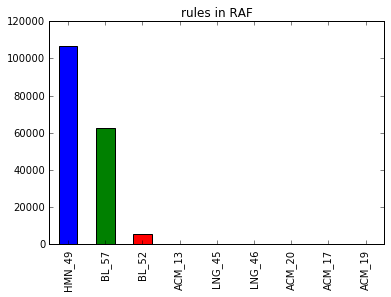

In [329]:
df['RAF_ACTIVATED_RULE_ID'].value_counts().plot(kind='bar',title='rules in RAF');

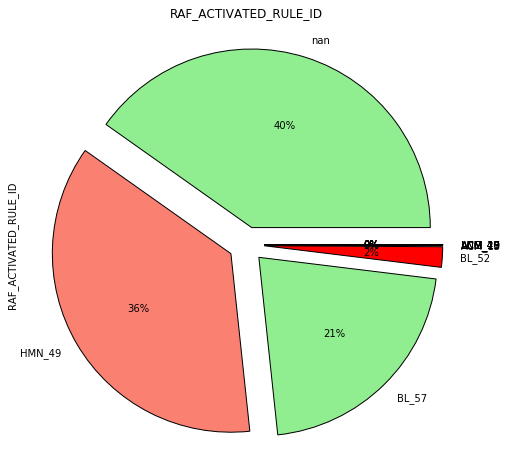

In [330]:
df['RAF_ACTIVATED_RULE_ID'].value_counts(dropna=False).plot(kind="pie",autopct='%1.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1),colors=['lightgreen', 'salmon','lightgreen','red', 'salmon', 'salmon', 'salmon', 'salmon', 'salmon', 'salmon'],figsize=(8,8),title='RAF_ACTIVATED_RULE_ID');

*As we can see the most "popular" rule is HMN_49 and BL_57 , later we will investigate this rules*

#### Call end clear cause ( written by RAF )

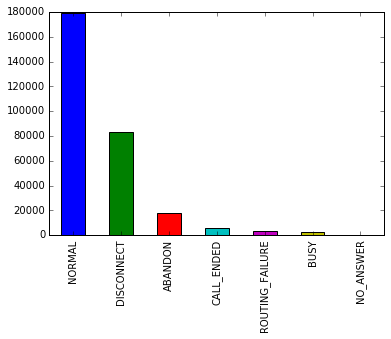

In [331]:
df['SESSION_DESC'].value_counts().plot(kind='bar');

In [332]:
df_raf= df[df['RAF_ACTIVATED_RULE_ID'].notnull()]

In [333]:
df_raf['SESSION_DESC'].value_counts()

NORMAL             174304
DISCONNECT             34
CALL_ENDED             26
ABANDON                16
ROUTING_FAILURE         6
Name: SESSION_DESC, dtype: int64

*We don't have any information about the call after we catch rule , because we send continue and not continue + RRB ( like for non matched rules call)*

*All the calls caught by rule get end_call_cause = NORMAL , we don't track after them ( only for LNG and ACC)*

#### Most popular destination for DTAG users (outbound)? most popular users countries for inbound?  

In [334]:
df_inbound  = df[df['ROAMING_TYPE'] =='INB']
df_outbound  = df[df['ROAMING_TYPE'] =='OUT']

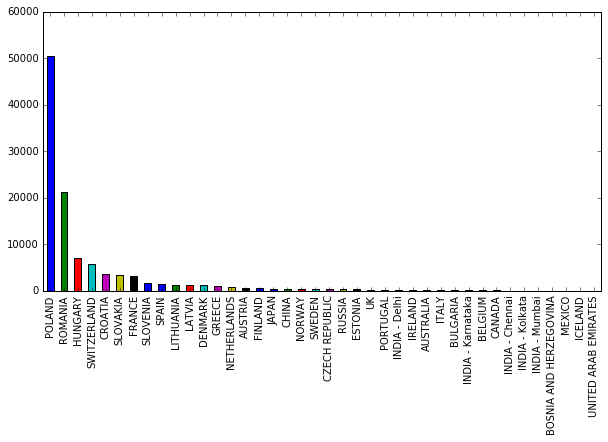

In [335]:
df_inbound['HOME_COUNTRY_NAME'].value_counts()[:40].plot(kind='bar',figsize=(10,5));

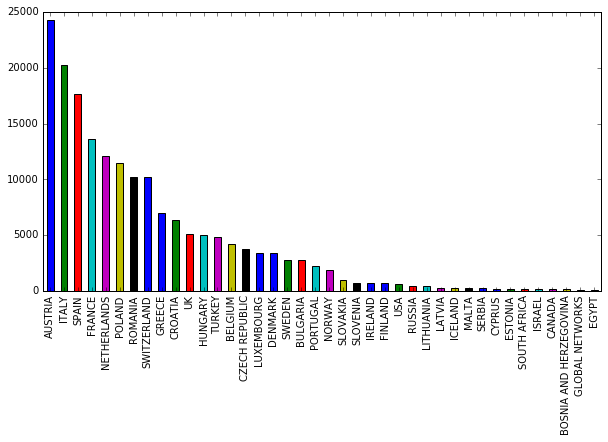

In [336]:
df_outbound['VISITED_COUNTRY_NAME'].value_counts()[:40].plot(kind='bar',figsize=(10,5));

#### How many calls barred by RAF ?

In [337]:
df_block = df[df['RAF_EVENT_REPLY'] == 1 ]
print("{} calls were barred by RAF".format(len(df_block)))

5380 calls were barred by RAF


#### Which rules barred those calls ? 

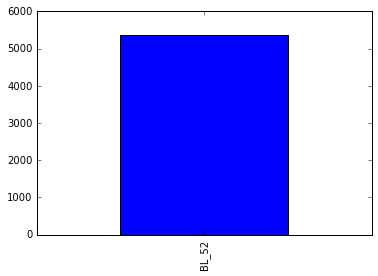

In [338]:
df_block['RAF_ACTIVATED_RULE_ID'].value_counts().plot(kind='bar');

*So it's pretty clear ;-)*

#### Let's explore rule HMN_49 who handled more than 100000 calls ..

In [339]:
df[df['RAF_ACTIVATED_RULE_ID'] == 'HMN_49']['ROAMING_TYPE'].value_counts()

INB    106416
Name: ROAMING_TYPE, dtype: int64

*this rule is activate only in INBOUND calls , it's check the country of the visiting user , let's see all the countries define in this rule*

In [340]:
df[df['RAF_ACTIVATED_RULE_ID'] == 'HMN_49']['HOME_COUNTRY_NAME'].unique()

array(['POLAND', 'SWITZERLAND', 'ROMANIA', 'LATVIA', 'CANADA',
       'LITHUANIA', 'HUNGARY', 'CHINA', 'ALBANIA', 'SLOVAKIA', 'CROATIA',
       'FINLAND', 'SPAIN', 'RUSSIA', 'NETHERLANDS', 'INDIA - Kolkata',
       'NORWAY', 'SLOVENIA', 'AUSTRIA', 'JAPAN', 'DENMARK', 'FRANCE',
       'KAZAKHSTAN', 'FAROE ISLANDS', 'INDIA - Chennai', 'GREECE',
       'IRELAND', 'INDIA - Delhi', 'AUSTRALIA', 'ESTONIA',
       'INDIA - Karnataka', 'HONG KONG', 'INDIA - Orissa',
       'BOSNIA AND HERZEGOVINA', 'BULGARIA', 'ITALY', 'BELGIUM',
       'CZECH REPUBLIC', 'PORTUGAL', 'INDIA - Maharashtra',
       'INDIA - Andhra Pradesh', 'BANGLADESH', 'UK', 'UKRAINE',
       'MADAGASCAR', 'TAIWAN', 'INDONESIA', 'KOREA (SOUTH)',
       'INDIA - Punjab', 'ICELAND', 'SWEDEN', 'INDIA - Tamil Nadu',
       'INDIA - UP West', 'MOLDOVA', 'INDIA - Bihar', 'USA',
       'INDIA - Mumbai', 'THAILAND', 'EGYPT', 'MALAYSIA', 'KUWAIT',
       'UNITED ARAB EMIRATES', 'ISRAEL', 'INDIA - UP East',
       'SOUTH AFRICA', 'INDIA 

*Now we can understand why raf handled so many calls ...*

### EDA Conclusion

We can see that 39% of the calls were handled by RAF as potential fraud (i.e catch by a rule).
The first Idea was to find the similarity between calls to find potential fraud calls that are very similar to those catch by RAF , but , due to the fact that the rule of DTAG are very "large" I change the goal of this project.
After EDA we can see that 5380 calls were released by RAF , so the goal is to "learn" this calls to find further fraud calls with the same behaviour but from others subscribers.

# DATA CLEANING part 2

*EDA done, we don't need anymore all the columns "name" , we have id columns*

In [341]:
df = df.drop(["HOME_COUNTRY_NAME","VISITED_COUNTRY_NAME","HOME_NETWORK_NAME","VISITED_NETWORK_NAME","CALL_END_CLEAR_CAUSE_NAME"],axis=1)

*In order to be in phase with the reality we need to delete all the column wrote by RAF and let only those given by the network the "metadata" of the call*

In [342]:
df = df.drop(["RAF_CRM_NOTIFICATION_FLAG","RAF_EVENT_REPLY","RAF_ACTIVATED_RULE_ID","RAF_NORMALIZED_DN","RAF_DN_PRE_NORMALIZATION","CALL_END_CLEAR_CAUSE_ID","CALL_END_NETWORK_CLEAR_CAUSE"],axis=1)

In [343]:
df.shape

(291605, 22)

*Due to the fact that call handled by RAF return CONTINUE + DEASSIGN I don't have any information about the call duration session end etc .. It's an huge lack of information because it's a basic info of each call ...*

In [344]:
df = df.drop(["SESSION_END_TS","SESSION_DESC","SESSION_TS_ANSWER","SESSION_TS_DISCONNECT","SESSION_DUR_SEC"],axis=1)

#### getDummies
* CALL_TYPE
* ROAMING_TYPE
* DN_IN_NOA
* CAMEL_PHASE
* RAF_NORMALIZE_TYPE

In [345]:
df = pd.get_dummies(df, columns=["CALL_TYPE","ROAMING_TYPE","DN_IN_NOA","RAF_NORMALIZE_TYPE"],sparse=True)

#### LabelEncoder
* EXTERNAL_CALL_REF_NUM
* IMSI
* MSISDN

In [346]:
from sklearn.preprocessing import LabelEncoder
le_cols = []
for c in ["EXTERNAL_CALL_REF_NUM","IMSI","MSISDN"]:
            le = LabelEncoder()
            le.fit(df[c])
            le_cols.append(le)
            df[c] = le.transform(df[c])

In [347]:
df.head()

,IMSI,MSISDN,HOME_COUNTRY_ID,VISITED_COUNTRY_ID,HOME_NETWORK_ID,VISITED_NETWORK_ID,DN_ORIG,CURRENT_MSC_GT,SCCP_CALLED_GT,SESSION_START_TS,EXTERNAL_CALL_REF_NUM,CAMEL_PHASE,RAF_STATUS,CALL_TYPE_MF,CALL_TYPE_MO,ROAMING_TYPE_INB,ROAMING_TYPE_OUT,DN_IN_NOA_1,DN_IN_NOA_2,DN_IN_NOA_4,RAF_NORMALIZE_TYPE_1,RAF_NORMALIZE_TYPE_2,RAF_NORMALIZE_TYPE_3,RAF_NORMALIZE_TYPE_4
0,145979,115112,164,175,58,39,491733268714,41789310205,4917007525,27.06.19 06:50:16.304,52268,2,0,0,1,0,1,0,0,1,1,0,0,0
1,7054,3843,164,105,58,55,491712XXXXXX,48602007070,4917007529,27.06.19 06:59:56.214,193031,2,0,0,1,0,1,0,0,1,1,0,0,0
2,51456,23126,164,182,58,296,491700XXXXXX,30971400000,4917007531,27.06.19 07:00:00.137,79852,2,1,0,1,0,1,0,0,1,1,0,0,0
3,1629,967,164,101,58,324,4915121XXXXXX,385980110,4917007531,27.06.19 06:59:17.042,84078,2,0,0,1,0,1,0,0,1,1,0,0,0
4,475,15681,105,164,55,58,48510XXXXXX,491700970000,491600980760,27.06.19 07:00:00.218,89585,2,1,0,1,1,0,0,0,1,1,0,0,0


## Feature engeniering

Feature Engineering: The process of taking raw data and extracting or creating new features that allow a machine learning model to learn a mapping beween these features and the target. This might mean taking transformations of variables. Generally, feature engineering is adding additional features derived from the raw data.

#### Add feature about time :
* the hour of the call
* if the call was on WE or not 

In [348]:
df['SESSION_START_TS'] = pd.to_datetime(df['SESSION_START_TS']) 

In [349]:
df['SESSION_START_HOUR'] = df['SESSION_START_TS'].dt.hour

In [350]:
def getIfDateWE(date):
    weekno = date.weekday()
    if weekno<5:
        return 0
    else:
        return 1

In [351]:
df['SESSION_START_WE'] = df['SESSION_START_TS'].apply(lambda date : getIfDateWE(date))

In [352]:
df.head()

,IMSI,MSISDN,HOME_COUNTRY_ID,VISITED_COUNTRY_ID,HOME_NETWORK_ID,VISITED_NETWORK_ID,DN_ORIG,CURRENT_MSC_GT,SCCP_CALLED_GT,SESSION_START_TS,EXTERNAL_CALL_REF_NUM,CAMEL_PHASE,RAF_STATUS,CALL_TYPE_MF,CALL_TYPE_MO,ROAMING_TYPE_INB,ROAMING_TYPE_OUT,DN_IN_NOA_1,DN_IN_NOA_2,DN_IN_NOA_4,RAF_NORMALIZE_TYPE_1,RAF_NORMALIZE_TYPE_2,RAF_NORMALIZE_TYPE_3,RAF_NORMALIZE_TYPE_4,SESSION_START_HOUR,SESSION_START_WE
0,145979,115112,164,175,58,39,491733268714,41789310205,4917007525,2019-06-27 06:50:16.304,52268,2,0,0,1,0,1,0,0,1,1,0,0,0,6,0
1,7054,3843,164,105,58,55,491712XXXXXX,48602007070,4917007529,2019-06-27 06:59:56.214,193031,2,0,0,1,0,1,0,0,1,1,0,0,0,6,0
2,51456,23126,164,182,58,296,491700XXXXXX,30971400000,4917007531,2019-06-27 07:00:00.137,79852,2,1,0,1,0,1,0,0,1,1,0,0,0,7,0
3,1629,967,164,101,58,324,4915121XXXXXX,385980110,4917007531,2019-06-27 06:59:17.042,84078,2,0,0,1,0,1,0,0,1,1,0,0,0,6,0
4,475,15681,105,164,55,58,48510XXXXXX,491700970000,491600980760,2019-06-27 07:00:00.218,89585,2,1,0,1,1,0,0,0,1,1,0,0,0,7,0


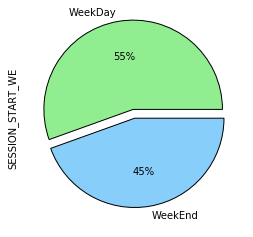

In [354]:
df['SESSION_START_WE'].value_counts().plot(kind="pie",autopct='%1.0f%%',colors=['lightgreen', 'lightskyblue'],explode=(0.1, 0),figsize=(4,4),labels=['WeekDay','WeekEnd']);

#### Add feature for length of DN

In [228]:
df['DN_ORIG_LEN'] = df['DN_ORIG'].apply(lambda x : len(x))
df['DN_ORIG']= df['DN_ORIG'].apply(lambda x : x[:5])

In [229]:
def removeXLet(dnOrig):
    res = ''
    for number in dnOrig:
        if number == 'X' or number == '*' or number == '#':
            res = res + '0'
        else :
            res = res + number
    return res

In [230]:
df['DN_ORIG'] = df['DN_ORIG'].apply(removeXLet)

*models accept only numeric value , so need to convert each column in numerical*

In [231]:
df['DN_ORIG'] = df['DN_ORIG'].astype(int)

In [232]:
df.head()

,IMSI,MSISDN,HOME_COUNTRY_ID,VISITED_COUNTRY_ID,HOME_NETWORK_ID,VISITED_NETWORK_ID,DN_ORIG,DN_IN_NOA,CALL_TYPE,ROAMING_TYPE,CURRENT_MSC_GT,SCCP_CALLED_GT,SESSION_START_TS,EXTERNAL_CALL_REF_NUM,CAMEL_PHASE,RAF_NORMALIZE_TYPE,RAF_STATUS,SESSION_START_HOUR,SESSION_START_WE,DN_ORIG_LEN
0,262017444077152,491605839415,164,175,58,39,49173,4,MO,OUT,41789310205,4917007525,2019-06-27 06:50:16.304,04D11423409274,2,1,0,6,0,12
1,$2a$04$m3vFo49du.gqajd85FBEne6ey0BIWyBE55AoFBF...,$2a$04$Bnykut954sIf2sEmwuDmoO2c0JXnb.r3BeqHd.l...,164,105,58,55,49171,4,MO,OUT,48602007070,4917007529,2019-06-27 06:59:56.214,2E864D32A3,2,1,0,6,0,12
2,$2a$04$m3vFo49du.gqajd85FBEney5WXxNPhj/6rWUrI8...,$2a$04$Bnykut954sIf2sEmwuDmoOQ3TQrwdVBoChy/B6b...,164,182,58,296,49170,4,MO,OUT,30971400000,4917007531,2019-06-27 07:00:00.137,04D114844072C2,2,1,1,7,0,12
3,$2a$04$m3vFo49du.gqajd85FBEne0.nmboVB9WIIhaDKj...,$2a$04$Bnykut954sIf2sEmwuDmoO/BWbhPRndiJz6NPDr...,164,101,58,324,49151,4,MO,OUT,385980110,4917007531,2019-06-27 06:59:17.042,04D114A300F530,2,1,0,6,0,13
4,$2a$04$m3vFo49du.gqajd85FBEne.ZMTQ1xguNZa6XgiA...,$2a$04$Bnykut954sIf2sEmwuDmoOH5/puP4OEVFQsK8mW...,105,164,55,58,48510,4,MO,INB,491700970000,491600980760,2019-06-27 07:00:00.218,04D114B3805142,2,1,1,7,0,11


#### Add feature : tentative's number of calls per IMSI in one hour 

In [233]:
#df['New_ID'] = df.index 

In [234]:
#df.head()

In [235]:
def numberOfTentative(call):
    newId =  call['New_ID']
    if newId % 5000 == 0:
        print datetime.now()
    start_date = call['SESSION_START_TS'] - timedelta(minutes=30)
    end_date = call['SESSION_START_TS'] + timedelta(minutes=30)
    currentDf = df[df['IMSI'] == call['IMSI']]
    tentatives = currentDf[(currentDf['SESSION_START_TS'] > start_date) & (currentDf['SESSION_START_TS'] <= end_date)].shape[0]
    return tentatives

In [236]:
#df["NUM_OF_TENTATIVE"] = df.apply(numberOfTentative,axis=1)

In [237]:
#df['NUM_OF_TENTATIVE'].value_counts()

In [243]:
df = df.drop(["SESSION_START_TS"],axis=1)

In [244]:
df.head()

,IMSI,MSISDN,HOME_COUNTRY_ID,VISITED_COUNTRY_ID,HOME_NETWORK_ID,VISITED_NETWORK_ID,DN_ORIG,CURRENT_MSC_GT,SCCP_CALLED_GT,EXTERNAL_CALL_REF_NUM,CAMEL_PHASE,RAF_STATUS,SESSION_START_HOUR,SESSION_START_WE,DN_ORIG_LEN,CALL_TYPE_MF,CALL_TYPE_MO,ROAMING_TYPE_INB,ROAMING_TYPE_OUT,DN_IN_NOA_1,DN_IN_NOA_2,DN_IN_NOA_4,RAF_NORMALIZE_TYPE_1,RAF_NORMALIZE_TYPE_2,RAF_NORMALIZE_TYPE_3,RAF_NORMALIZE_TYPE_4
0,145979,115112,164,175,58,39,49173,41789310205,4917007525,52268,2,0,6,0,12,0,1,0,1,0,0,1,1,0,0,0
1,7054,3843,164,105,58,55,49171,48602007070,4917007529,193031,2,0,6,0,12,0,1,0,1,0,0,1,1,0,0,0
2,51456,23126,164,182,58,296,49170,30971400000,4917007531,79852,2,1,7,0,12,0,1,0,1,0,0,1,1,0,0,0
3,1629,967,164,101,58,324,49151,385980110,4917007531,84078,2,0,6,0,13,0,1,0,1,0,0,1,1,0,0,0
4,475,15681,105,164,55,58,48510,491700970000,491600980760,89585,2,1,7,0,11,0,1,1,0,0,0,1,1,0,0,0


*******************************************************************************************************************************

## Data Sience Model

In [76]:
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
pd.set_option('display.max_columns', None)
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')
import pydotplus
from sklearn import tree

In [77]:
df = pd.read_csv('dfMoco.csv')

In [78]:
df.head()

,Unnamed: 0,IMSI,MSISDN,HOME_COUNTRY_ID,VISITED_COUNTRY_ID,HOME_NETWORK_ID,VISITED_NETWORK_ID,DN_ORIG,CURRENT_MSC_GT,SCCP_CALLED_GT,EXTERNAL_CALL_REF_NUM,CAMEL_PHASE,RAF_STATUS,SESSION_START_HOUR,SESSION_START_WE,DN_ORIG_LEN,NUM_OF_TENTATIVE,CALL_TYPE_MF,CALL_TYPE_MO,ROAMING_TYPE_INB,ROAMING_TYPE_OUT,DN_IN_NOA_1,DN_IN_NOA_2,DN_IN_NOA_4,RAF_NORMALIZE_TYPE_1,RAF_NORMALIZE_TYPE_2,RAF_NORMALIZE_TYPE_3,RAF_NORMALIZE_TYPE_4
0,0,145979,115112,164,175,58,39,49173,41789310205,4917007525,52268,2,0,6,0,12,4,0,1,0,1,0,0,1,1,0,0,0
1,1,7054,3843,164,105,58,55,49171,48602007070,4917007529,193031,2,0,6,0,12,1,0,1,0,1,0,0,1,1,0,0,0
2,2,51456,23126,164,182,58,296,49170,30971400000,4917007531,79852,2,1,7,0,12,1,0,1,0,1,0,0,1,1,0,0,0
3,3,1629,967,164,101,58,324,49151,385980110,4917007531,84078,2,0,6,0,13,2,0,1,0,1,0,0,1,1,0,0,0
4,4,475,15681,105,164,55,58,48510,491700970000,491600980760,89585,2,1,7,0,11,6,0,1,1,0,0,0,1,1,0,0,0


In [79]:
#For Random forest (best model)
df = df.drop(['Unnamed: 0','IMSI','MSISDN'], axis=1)

#For logistic Regression (use for pratice)
#df = df.drop('Unnamed: 0', axis=1)

In [80]:
def replaceRafStatusValue(value):
    if value == 0 or value == 1 :
        return 0
    else :
        return 1

In [81]:
df['RAF_STATUS'] = df['RAF_STATUS'].apply(replaceRafStatusValue)

In [82]:
df['RAF_STATUS'].value_counts()

0    286225
1      5380
Name: RAF_STATUS, dtype: int64

In [83]:
df.shape

(291605, 25)

### Imbalanced classes

We are facing to a problem known as imbalanced classes , the class we want to predict is , for example here , only 2% of our data.
This problem is very frequent in problems of fraud detection and chrun prediction.
Some methods :
* Down Sampling
* Create Synthetic Samples (Data Augmentation)
* Penalizing

The better way to understand the need of those methods is to run a model of machine learning and to see the outpout in our case for each sample he will told that it's NOT a fraud and the model will be right in 98% of the case .. good accuracy! But it's not what we want ...

#### Stratify - split with same distribution

In [84]:
X = df.drop('RAF_STATUS', axis=1)
y = df['RAF_STATUS']
X_train, X_validate, y_train, y_validate = train_test_split(X, y,  test_size=0.3, stratify=y, random_state = 22)

In [85]:
X_train = X_train.merge(y_train.to_frame(), left_index=True, right_index=True)

In [86]:
X_train.shape

(204123, 25)

In [87]:
X_train['RAF_STATUS'].value_counts()

0    200357
1      3766
Name: RAF_STATUS, dtype: int64

#### DownSampling majority class

In [88]:
# Separate majority and minority classes
df_majority = X_train[X_train.RAF_STATUS==0]
df_minority = X_train[X_train.RAF_STATUS==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.RAF_STATUS.value_counts()


0    10000
1     3766
Name: RAF_STATUS, dtype: int64

#### Split Into Training and Testing Sets

In [89]:
df_train, df_test = split(df_downsampled, test_size=0.3, random_state=14)

In [90]:
X_train_train = df_train.drop('RAF_STATUS', axis=1)
y_train_train = df_train['RAF_STATUS']
X_train_test = df_test.drop('RAF_STATUS', axis=1)
y_train_test = df_test['RAF_STATUS']

## MODELS

### Logistic Regression

In [255]:
# Train model
clf_2 = LogisticRegression().fit(X_train_train, y_train_train)
 
# Predict on test set
pred_y_2 = clf_2.predict(X_train_train)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y_train_train, pred_y_2))

[0 1]
0.6215857359635811


In [256]:
cm = confusion_matrix(y_true=y_train_train,
                      y_pred=pred_y_2)

In [257]:
pd.DataFrame(cm, 
             index=clf_2.classes_, 
             columns=clf_2.classes_)

,0,1
0,1881,745
1,1250,1396


In [258]:
y_pred=clf_2.predict(X_train_test)
print("acc : {}".format(accuracy_score(y_train_test, y_pred)))
print("\n")
print(pd.DataFrame(confusion_matrix(y_train_test, y_pred)))
print("\n")
print(classification_report(y_train_test, y_pred))

acc : 0.61814159292


     0    1
0  822  318
1  545  575


              precision    recall  f1-score   support

           0       0.60      0.72      0.66      1140
           1       0.64      0.51      0.57      1120

   micro avg       0.62      0.62      0.62      2260
   macro avg       0.62      0.62      0.61      2260
weighted avg       0.62      0.62      0.61      2260



In [259]:
scores = clf_2.predict_proba(X_train_test)
print(scores[::300])
scores.shape

[[0.50334862 0.49665138]
 [0.9971408  0.0028592 ]
 [0.50430148 0.49569852]
 [0.50174585 0.49825415]
 [0.36292171 0.63707829]
 [0.9971408  0.0028592 ]
 [0.50394325 0.49605675]
 [0.37752966 0.62247034]]


(2260L, 2L)

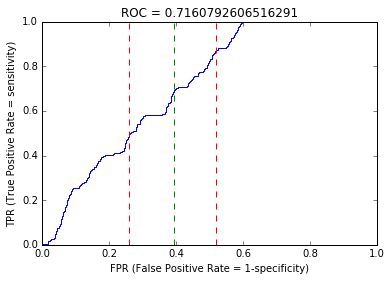

In [264]:
fpr, tpr, thresholds = roc_curve(y_train_test.values, scores[:,1])
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.axvline(x=0.26, color='r', linestyle='--',lw=1)
plt.axvline(x=0.395, color='g', linestyle='--',lw=1)
plt.axvline(x=0.52, color='r', linestyle='--',lw=1)
plt.title('ROC = '+str(roc_auc_score(y_train_test.values, scores[:,1])));

In [304]:
a = np.where(scores[:,1] > 0.49605, 1, 0)
print('acc=', accuracy_score(y_train_test, a))
cm = confusion_matrix(y_train_test, a)
print('tpr=', float(cm[1][1])/float(cm[1][0]+cm[1][1]))
print('fpr=', float(cm[0][1])/float((cm[0][0]+cm[0][1])))
classes=['No', 'Yes']
pd.DataFrame(cm, index=classes, columns=classes)

('acc=', 0.647787610619469)
('tpr=', 0.6901785714285714)
('fpr=', 0.393859649122807)


,No,Yes
No,691,449
Yes,347,773


#### Validate the model

In [306]:
scores_validate = clf_2.predict_proba(X_validate)
a = np.where(scores_validate[:,1] > 0.49605, 1, 0)
print('acc=', accuracy_score(y_validate, a))
cm = confusion_matrix(y_validate, a)
print('tpr=', float(cm[1][1])/float(cm[1][0]+cm[1][1]))
print('fpr=', float(cm[0][1])/float((cm[0][0]+cm[0][1])))
classes=['No', 'Yes']
pd.DataFrame(cm, index=classes, columns=classes)

('acc=', 0.5954710683340573)
('tpr=', 0.6771995043370508)
('fpr=', 0.4060651232123725)


,No,Yes
No,51000,34868
Yes,521,1093


#### Logistic Regression Conclusion

This model didn't give us satisfactory results , we can see that to "catch" fraud we need to define a lot of non fraud in fraud predict .. 
Let's try another model stronger for categorical data ( like our data )...

### Random Forest

In [91]:
clf = RandomForestClassifier()

#### Cross Validation

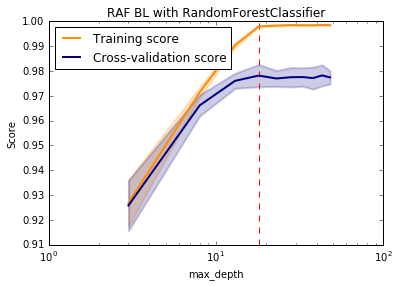

In [100]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits

from sklearn.model_selection import validation_curve


param='max_depth'
param_range = range(3,50,5)
train_scores, test_scores = validation_curve(RandomForestClassifier(), X_train_train.append(X_train_test), y_train_train.append(y_train_test),
                                            param_name=param,
                                            param_range=param_range, cv=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("RAF BL with RandomForestClassifier")
plt.xlabel(param)
plt.ylabel("Score")
plt.axvline(x=18, color='r', linestyle='--',lw=1)
#plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [101]:
#clf = tree.DecisionTreeClassifier(max_depth=5,min_samples_split=10,min_samples_leaf=10)
clf = RandomForestClassifier(max_depth=25,random_state=10)

In [102]:
def report(y, y_pred, classes):
    acc = accuracy_score(y, y_pred)
                        
    cm = pd.DataFrame(confusion_matrix(y, y_pred), 
                      index=classes, 
                      columns=classes)
    rep = classification_report(y, y_pred)

    
    return '{:.3f}\n\n{}\n\n{}'.format(acc, cm, rep)

In [103]:
clf = clf.fit(X_train_train, y_train_train)
y_pred=clf.predict(X_train_test)
print( report(y_train_test,y_pred, ['No','Yes']))

0.977

       No   Yes
No   2975    43
Yes    50  1062

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3018
           1       0.96      0.96      0.96      1112

   micro avg       0.98      0.98      0.98      4130
   macro avg       0.97      0.97      0.97      4130
weighted avg       0.98      0.98      0.98      4130



### Feature Importance

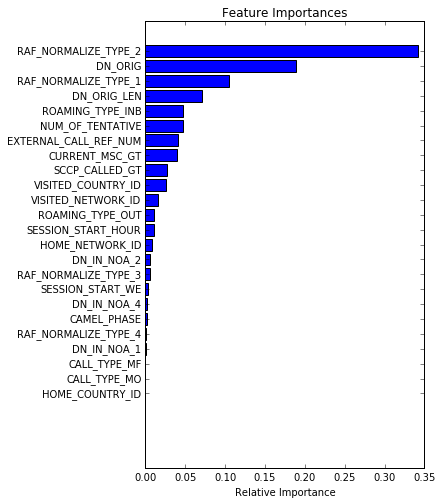

In [96]:
features = X_train_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(5,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [97]:
import collections
dot_data = tree.export_graphviz(clf.estimators_[0],
                                feature_names=X_train_train.columns,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

True

#### Validate the model

In [98]:
y_validate_pred=clf.predict(X_validate)
print(report(y_validate,y_validate_pred, ['No','Yes']))

0.983

        No   Yes
No   84439  1429
Yes     87  1527

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85868
           1       0.52      0.95      0.67      1614

   micro avg       0.98      0.98      0.98     87482
   macro avg       0.76      0.96      0.83     87482
weighted avg       0.99      0.98      0.99     87482



*Need to check the 1429 calls perhaps they are fraud ...*

# Conclusion & What next

* we get good results with RandomForest model , however we need to test the model with more data that we can get from DTAG . 
  with more data we will need to retrain the model and perhaps find other feature that are important .

* More Data will give us more information about , for example , "session start hour " or " WeekEnd or Not" etc...
  Add some features are another part to improve results , like , customer's seniority etc ..

* The goal now is to find the best product based on data science to avoid fraud .